## Задача поиска схожих по смыслу предложений

Мы будем ранжировать вопросы [StackOverflow](https://stackoverflow.com) на основе семантического векторного представления 

## Задача ранжирования(Learning to Rank)

* $X$ - множество объектов
* $X^l = \{x_1, x_2, ..., x_l\}$ - обучающая выборка
<br>На обучающей выборке задан порядок между некоторыми элементами, то есть нам известно, что некий объект выборки более релевантный для нас, чем другой:
* $i \prec j$ - порядок пары индексов объектов на выборке $X^l$ c индексами $i$ и $j$
### Задача:
построить ранжирующую функцию $a$ : $X \rightarrow R$ такую, что
$$i \prec j \Rightarrow a(x_i) < a(x_j)$$

<img src="https://d25skit2l41vkl.cloudfront.net/wp-content/uploads/2016/12/Featured-Image.jpg" width=500, height=450>

### Embeddings

Будем использовать предобученные векторные представления слов на постах Stack Overflow.<br>
[A word2vec model trained on Stack Overflow posts](https://github.com/vefstathiou/SO_word2vec)

In [2]:
import math
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from copy import deepcopy
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import spacy
import pymorphy2
from nltk.tokenize import WordPunctTokenizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [4]:
!wget https://zenodo.org/record/1199620/files/SO_vectors_200.bin

--2022-03-14 12:49:10--  https://zenodo.org/record/1199620/files/SO_vectors_200.bin
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1453905423 (1.4G) [application/octet-stream]
Saving to: ‘SO_vectors_200.bin’

SO_vectors_200.bin  100%[===================>]   1.35G  6.78MB/s    in 4m 46s  

2022-03-14 12:53:58 (4.85 MB/s) - ‘SO_vectors_200.bin’ saved [1453905423/1453905423]



In [27]:
wv_embeddings = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

#### Как пользоваться этими векторами?

Посмотрим на примере одного слова, что из себя представляет embedding

In [23]:
my_dog = 'dog'
if my_dog in wv_embeddings:
    print(wv_embeddings[my_dog].dtype, wv_embeddings[my_dog].shape)

float32 (200,)


In [24]:
print(f"Num of words: {len(wv_embeddings.index_to_key)}")

Num of words: 1787145


Найдем наиболее близкие слова к слову `dog`:

#### Вопрос 1:
* Входит ли слов `cat` топ-5 близких слов к слову `dog`? Какое место? 

In [25]:
MY_DOG = 'dog'
MY_CAT = 'cat'
TOP = 5
COUNT = 0
idxs = []

for word in wv_embeddings.most_similar(positive=[MY_DOG], topn = TOP):
    if MY_CAT == word[0]:
        print(f'Слово {MY_CAT} входит в топ-{TOP} к слову {MY_DOG} и находится на \
{wv_embeddings.most_similar(positive=[MY_DOG], topn = TOP).index(word) + 1} месте')
        break
    elif MY_CAT in word[0]:
        COUNT += 1
        idxs.append(wv_embeddings.most_similar(positive=[MY_DOG], topn = TOP).index(word) + 1)
    else:
        COUNT += 1

if COUNT == TOP:
    print(f'Слово "{MY_CAT}" НЕ входит в топ-{TOP} близких к слову "{MY_DOG}"')
if len(idxs) != 0:
    print(f'Однако, на {idxs[0]} позиции в топ-{TOP} находится слово \
"{wv_embeddings.most_similar(positive=[MY_DOG], topn = TOP)[idxs[0]-1][0]}"')

Слово "cat" НЕ входит в топ-5 близких к слову "dog"
Однако, на 4 позиции в топ-5 находится слово "cats"


### Векторные представления текста

Перейдем от векторных представлений отдельных слов к векторным представлениям вопросов, как к **среднему** векторов всех слов в вопросе. Если для какого-то слова нет предобученного вектора, то его нужно пропустить. Если вопрос не содержит ни одного известного слова, то нужно вернуть нулевой вектор.

In [22]:
# Токенайзер, основанный на регулярных выражения, возвращающий 
# слова без знаков пунктуации и без применения нормализации.

class MyTokenizer:
    def __init__(self):
        pass
    def tokenize(self, text):
        return re.findall('\w+', text)
    
tokenizer = MyTokenizer()

In [23]:
def question_to_vec(question, embeddings, tokenizer, dim=200):
    """
        question: строка
        embeddings: наше векторное представление
        dim: размер любого вектора в нашем представлении
        
        return: векторное представление для вопроса
    """
    embed_list = []
    for word in tokenizer.tokenize(question.lower()):
        try:
            embed_list.append(embeddings[word])
        except (KeyError):
            continue
    return np.mean(embed_list, axis=0) if len(embed_list) > 0 else np.zeros(dim, dtype='float32')

Теперь у нас есть метод для создания векторного представления любого предложения.

#### Вопрос 2:
* Какая третья(с индексом 2) компонента вектора предложения `I love neural networks` (округлите до 2 знаков после запятой)?

In [25]:
text = 'I love neural networks'

In [243]:
# Токенайзер на регулярных выражениях
tokenizer = MyTokenizer()
round(question_to_vec(text, wv_embeddings, tokenizer)[2],2)

-1.29

In [244]:
MyTokenizer().tokenize(text) #результаты токенизации классом MyTokenizer

['I', 'love', 'neural', 'networks']

In [28]:
# Токенайзер Spacy помимо слов токенизирует знаки пунктуации и применяет нормализацию (лемматизацию)
nlp = spacy.load('en_core_web_sm')

class SpacyTokenizer:
    def __init__(self):
        pass
    def tokenize(self, text):
        spacy_results = nlp(text)
        return [token.lemma_ for token in spacy_results]
    
spacy_tokenizer = SpacyTokenizer()
round(question_to_vec(text, wv_embeddings, spacy_tokenizer)[2],2)

-1.41

In [246]:
SpacyTokenizer().tokenize(text) #результаты токенизации классом SpacyTokenizer

['I', 'love', 'neural', 'network']

In [13]:
# Токенайзер pymorphy2
class Pymorphy2Tokenizer:
    def __init__(self):
        pass
    def tokenize(self, text):
        morph = pymorphy2.MorphAnalyzer()
        pymorphy_results = list(map(lambda x: morph.parse(x), text.split(' ')))
        return [res[0].normal_form for res in pymorphy_results] 
    
pymorphy2_tokenizer = Pymorphy2Tokenizer()
round(question_to_vec(text, wv_embeddings, pymorphy2_tokenizer)[2],2)

-1.29

In [14]:
Pymorphy2Tokenizer().tokenize(text) #результаты токенизации классом Pymorphy2Tokenizer

['i', 'love', 'neural', 'networks']

In [29]:
# Токенайзер WordPunctTokenizer помимо слов токенизирует знаки пунктуации, но НЕ применяет нормализацию.
tk = WordPunctTokenizer()
round(question_to_vec(text, wv_embeddings, tk)[2],2)

-1.29

In [16]:
tk.tokenize(text) #результаты токенизации классом WordPunctTokenizer

['I', 'love', 'neural', 'networks']

### Оценка близости текстов

Представим, что мы используем идеальные векторные представления слов. Тогда косинусное расстояние между дублирующими предложениями должно быть меньше, чем между случайно взятыми предложениями. 

Сгенерируем для каждого из $N$ вопросов $R$ случайных отрицательных примеров и примешаем к ним также настоящие дубликаты. Для каждого вопроса будем ранжировать с помощью нашей модели $R + 1$ примеров и смотреть на позицию дубликата. Мы хотим, чтобы дубликат был первым в ранжированном списке.

#### Hits@K
Первой простой метрикой будет количество корректных попаданий для какого-то $K$:
$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, [rank\_q_i^{'} \le K],$$
* $\begin{equation*}
[x < 0 ] \equiv 
 \begin{cases}
   1, &x < 0\\
   0, &x \geq 0
 \end{cases}
\end{equation*}$ - индикаторная функция
* $q_i$ - $i$-ый вопрос
* $q_i^{'}$ - его дубликат
* $rank\_q_i^{'}$ - позиция дубликата в ранжированном списке ближайших предложений для вопроса $q_i$.

#### DCG@K
Второй метрикой будет упрощенная DCG метрика, учитывающая порядок элементов в списке путем домножения релевантности элемента на вес равный обратному логарифму номера позиции::
$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank\_q_i^{'})}\cdot[rank\_q_i^{'} \le K],$$
С такой метрикой модель штрафуется за большой ранк корректного ответа

#### Вопрос 3:
* Максимум `Hits@47 - DCG@1`?

Ответ: Максимальное значение РАЗНИЦЫ двух функций достигается при максимальном значении Уменьшаемого и минимальном значении Вычитаемого. Максимально возможное значение Hits@47 == 1, в том случае, когда дубликаты вопросов расположены среди первых 47 вариантов ответов, в число которых могут входить и отрицательные примеры. При этом минимальное значение DCG@1 == 0, в том случае, когда позиции дубликатов в ранжированном списке ближайших вопросов для вопроса 𝑞𝑖 не расположены на 1-ом месте. Соответственно, максимум Hits@47 - DCG@1 = 1 - 0 = 1. Что характерно для ситуации, когда дубликаты расположены на позициях с 2 по 47.

In [26]:
# Проверим наши выводы численными методами на искусственном примере
from ampligraph.evaluation.metrics import hits_at_n_score

# пусть N = 8 - количество исходных вопросов 𝑞𝑖 
# n (aka K) - длина рассматриваемого списка любых вариантов ответов перемешанные отрицательные примеры и дубликаты
K1 = 47
K2 = 1
rankings = np.array([3, 12, 6, 14, 35, 16, 42, 47]) # 𝑟𝑎𝑛𝑘_𝑞′ - позиции дубликатов в ранжированном списке ближайших вопросов для вопроса 𝑞𝑖

Hits = hits_at_n_score(rankings, n = K1)
DCG = round(sum([np.zeros(1)[0] if rank > K2 else math.log2(1 + rank)**(-1) for rank in rankings]) / rankings.shape[0],2)

print(f'\nHits@{K1} - DCG@{K2} = {Hits - DCG}\n\nHits@{K1} = {Hits}, DCG@{K2} = {DCG}')


Hits@47 - DCG@1 = 1.0

Hits@47 = 1.0, DCG@1 = 0.0


<img src='https://hsto.org/files/1c5/edf/dee/1c5edfdeebce4b71a86bdf986d9f88f2.jpg' width=400, height=200>

#### Пример оценок

Вычислим описанные выше метрики для игрушечного примера. 
Пусть
* $N = 1$, $R = 3$
* <font color='green'>"Что такое python?"</font> - вопрос $q_1$
* <font color='red'>"Что такое язык python?"</font> - его дубликат $q_i^{'}$

Пусть модель выдала следующий ранжированный список кандидатов:

1. "Как изучить с++?"
2. <font color='red'>"Что такое язык python?"</font>
3. "Хочу учить Java"
4. "Не понимаю Tensorflow"

$\Rightarrow rank\_q_i^{'} = 2$

Вычислим метрику *Hits@K* для *K = 1, 4*:

- [K = 1] $\text{Hits@1} =  [rank\_q_i^{'} \le 1)] = 0$
- [K = 4] $\text{Hits@4} =  [rank\_q_i^{'} \le 4] = 1$

Вычислим метрику *DCG@K* для *K = 1, 4*:
- [K = 1] $\text{DCG@1} = \frac{1}{\log_2(1+2)}\cdot[2 \le 1] = 0$
- [K = 4] $\text{DCG@4} = \frac{1}{\log_2(1+2)}\cdot[2 \le 4] = \frac{1}{\log_2{3}}$

#### Вопрос 4:
* Вычислите `DCG@10`, если $rank\_q_i^{'} = 9$(округлите до одного знака после запятой)

In [3]:
K = 10

rankings = np.array([9]) # 𝑟𝑎𝑛𝑘_𝑞′ - позиции дубликатов в ранжированном списке ближайших вопросов для вопроса 𝑞𝑖

DCG = round(sum([np.zeros(1)[0] if rank > K else math.log2(1 + rank)**(-1) for rank in rankings]) / rankings.shape[0],2)

print(f'\nDCG@{K} = {DCG}\n')


DCG@10 = 0.3



### HITS\_COUNT и DCG\_SCORE

Каждая функция имеет два аргумента: $dup\_ranks$ и $k$. $dup\_ranks$ является списком, который содержит рейтинги дубликатов(их позиции в ранжированном списке). Например, $dup\_ranks = [2]$ для примера, описанного выше.

In [30]:
def hits_count(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть  Hits@k
    """
    hits_value = round(sum([np.zeros(1)[0] if rank > k else np.ones(1)[0] for rank in dup_ranks]) / len(dup_ranks),3)
    return hits_value

In [31]:
def dcg_score(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть DCG@k
    """
    dcg_value = round(sum([np.zeros(1)[0] if rank > k else math.log2(1 + rank)**(-1) for rank in dup_ranks]) / len(dup_ranks),3)
    return dcg_value

Протестируем функции. Пусть $N = 1$, то есть один эксперимент. Будем искать копию вопроса и оценивать метрики.

In [42]:
copy_answers = ["How does the catch keyword determine the type of exception that was thrown",]

# наши кандидаты
candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                       "How does the catch keyword determine the type of exception that was thrown",
                       "NSLog array description not memory address",
                       "PECL_HTTP not recognised php ubuntu"],]
# dup_ranks — позиции наших копий, так как эксперимент один, то этот массив длины 1
dup_ranks = [2]

# вычисляем метрику для разных k
print('Ваш ответ HIT:', [hits_count(dup_ranks, k) for k in range(1, 5)])
print('Ваш ответ DCG:', [round(dcg_score(dup_ranks, k), 5) for k in range(1, 5)])

Ваш ответ HIT: [0.0, 1.0, 1.0, 1.0]
Ваш ответ DCG: [0.0, 0.631, 0.631, 0.631]


У вас должно получиться

In [43]:
# correct_answers - метрика для разных k
correct_answers = pd.DataFrame([[0, 1, 1, 1], [0, 1 / (np.log2(3)), 1 / (np.log2(3)), 1 / (np.log2(3))]],
                               index=['HITS', 'DCG'], columns=range(1,5))
correct_answers

,1,2,3,4
HITS,0,1.00000,1.00000,1.00000
DCG,0,0.63093,0.63093,0.63093


### Данные
[arxiv link](https://drive.google.com/file/d/1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_/edit)

`train.tsv` - выборка для обучения.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>**

`validation.tsv` - тестовая выборка.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>, <отрицательный пример 1>, <отрицательный пример 2>, ...**

In [112]:
!unzip stackoverflow_similar_questions.zip

unzip:  cannot find or open stackoverflow_similar_questions.zip, stackoverflow_similar_questions.zip.zip or stackoverflow_similar_questions.zip.ZIP.


Считайте данные.

In [34]:
def read_corpus(filename):
    data = []
    for line in open(filename, encoding='utf-8'):
        data.append(line.split('\t'))
    return data

Нам понадобиться только файл validation.

In [35]:
validation_data = read_corpus('./data/validation.tsv')

Кол-во строк

In [36]:
len(validation_data)

3760

Размер нескольких первых строк

In [37]:
for i in range(5):
    print(i + 1, len(validation_data[i]))

1 1001
2 1001
3 1001
4 1001
5 1001


### Ранжирование без обучения

Реализуйте функцию ранжирования кандидатов на основе косинусного расстояния. Функция должна по списку кандидатов вернуть отсортированный список пар (позиция в исходном списке кандидатов, кандидат). При этом позиция кандидата в полученном списке является его рейтингом (первый - лучший). Например, если исходный список кандидатов был [a, b, c], и самый похожий на исходный вопрос среди них - c, затем a, и в конце b, то функция должна вернуть список **[(2, c), (0, a), (1, b)]**.

In [42]:
def rank_candidates(question, candidates, embeddings, tokenizer, dim=200):
    """
        question: строка
        candidates: массив строк(кандидатов) [a, b, c]
        result: пары (начальная позиция, кандидат) [(2, c), (0, a), (1, b)]
    """
    result = []
    q_vec = question_to_vec(question, embeddings, tokenizer)
    
    for idx, elem in enumerate(candidates):
        candidate_vec = question_to_vec(elem, embeddings, tokenizer)
        result.append((idx, elem, cosine_similarity(q_vec.reshape(1, -1), candidate_vec.reshape(1, -1))[0][0]))
        
    result.sort(key=lambda x: x[2], reverse=True)
    
    return [elem[:-1] for elem in deepcopy(result)]

Протестируйте работу функции на примерах ниже. Пусть $N=2$, то есть два эксперимента

In [41]:
questions = ['converting string to list', 'Sending array via Ajax fails'] 

candidates = [['Convert Google results object (pure js) to Python object', # первый эксперимент
               'C# create cookie from string and send it',
               'How to use jQuery AJAX for an outside domain?'],
              
              ['Getting all list items of an unordered list in PHP',      # второй эксперимент
               'WPF- How to update the changes in list item of a list',
               'select2 not displaying search results']]

In [328]:
tokenizers = [MyTokenizer(), SpacyTokenizer(), Pymorphy2Tokenizer(), WordPunctTokenizer()]
rez_list = []

for tokenizer in tokenizers:
    for question, q_candidates in zip(questions, candidates):
        ranks = rank_candidates(question, q_candidates, wv_embeddings, tokenizer)
        rez_list.append("".join([str(i) for i in [elem[0] for elem in ranks]]))
        #print(f'{ranks}')
        #print()

df = pd.DataFrame()
df['Tokenizer'] = [str(i).split('.')[1].split(' ')[0] for i in tokenizers][:-1] + [[str(i).partition('(')[0] for i in tokenizers][-1]]
df['Эксперимент_1'] = rez_list[::2]
df['Эксперимент_2'] = rez_list[1::2]
df

,Tokenizer,Эксперимент_1,Эксперимент_2
0,MyTokenizer,102,021
1,SpacyTokenizer,102,021
2,Pymorphy2Tokenizer,012,012
3,WordPunctTokenizer,102,021


Для первого экперимента вы можете полностью сравнить ваши ответы и правильные ответы. Но для второго эксперимента два ответа на кандидаты будут <b>скрыты</b>(*)

In [ ]:
# должно вывести
results = [[(1, 'C# create cookie from string and send it'),
            (0, 'Convert Google results object (pure js) to Python object'),
            (2, 'How to use jQuery AJAX for an outside domain?')],
           [(*, 'Getting all list items of an unordered list in PHP'), #скрыт
            (*, 'select2 not displaying search results'), #скрыт
            (*, 'WPF- How to update the changes in list item of a list')]] #скрыт

Последовательность начальных индексов вы должны получить `для эксперимента 1`  1, 0, 2.

#### Вопрос 5:
* Какую последовательность начальных индексов вы получили `для эксперимента 2`(перечисление без запятой и пробелов, например, `102` для первого эксперимента?

In [329]:
# для токенайзеров - MyTokenizer(), SpacyTokenizer(), WordPunctTokenizer()
rez_2 = ''
for rank in ranks:
    rez_2 += str(rank[0])
print('\033[1m',rez_2)

 021


Теперь мы можем оценить качество нашего метода. Запустите следующие два блока кода для получения результата. Обратите внимание, что вычисление расстояния между векторами занимает некоторое время (примерно 10 минут). Можете взять для validation 1000 примеров.

In [330]:
tokenizer = MyTokenizer()

wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

  0%|          | 0/3760 [00:00<?, ?it/s]

In [331]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.410 | Hits@   1: 0.410
DCG@   5: 0.500 | Hits@   5: 0.580
DCG@  10: 0.521 | Hits@  10: 0.645
DCG@ 100: 0.568 | Hits@ 100: 0.875
DCG@ 500: 0.581 | Hits@ 500: 0.973
DCG@1000: 0.583 | Hits@1000: 1.000


In [332]:
tokenizer = SpacyTokenizer()

wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

  0%|          | 0/3760 [00:00<?, ?it/s]

In [333]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.392 | Hits@   1: 0.392
DCG@   5: 0.482 | Hits@   5: 0.561
DCG@  10: 0.503 | Hits@  10: 0.627
DCG@ 100: 0.549 | Hits@ 100: 0.850
DCG@ 500: 0.565 | Hits@ 500: 0.967
DCG@1000: 0.568 | Hits@1000: 1.000


In [30]:
tokenizer = WordPunctTokenizer()

wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    print(i)
    clear_output(wait=True)
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

1000


In [31]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.410 | Hits@   1: 0.410
DCG@   5: 0.500 | Hits@   5: 0.580
DCG@  10: 0.521 | Hits@  10: 0.645
DCG@ 100: 0.568 | Hits@ 100: 0.875
DCG@ 500: 0.581 | Hits@ 500: 0.973
DCG@1000: 0.583 | Hits@1000: 1.000


### Эмбеддинги, обученные на корпусе похожих вопросов

In [16]:
train_data = read_corpus('./data/train.tsv')

Улучшите качество модели.<br>Склеим вопросы в пары и обучим на них модель Word2Vec из gensim. Выберите размер window. Объясните свой выбор.

In [18]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

#### Эмбеддинги без нормализации (лемматизации)

Подготовим препроцессинг данных для обучения эмбеддингов. Используем слова в нижнем регистре, со знаками пунктуации и без использования нормализации. Кроме того, отфильтруем слова согласно стоп-листа.

In [39]:
def preproc_nltk(text):
    return ' '.join([word for word in word_tokenize(text.lower()) if word not in stopWords])

In [20]:
couple_list = [couple[0] + str(' ') + couple[1] for couple in train_data]
words = [preproc_nltk(question).split() for question in couple_list]

### with Skip-Gram

In [22]:
dcg_history = []
hits_history = []
for min_count in range(1,11):
    for window in range(1,11):
        embeddings_trained = Word2Vec(words,                    # data for model to train on
                                      vector_size=200,          # embedding vector size
                                      min_count=min_count,      # Ignores all words with total frequency lower than this. Consider words that occured at least 5 times
                                      window=window,            # Maximum distance between the current and predicted word within a sentence
                                      workers=4,                # Use these many worker threads to train the model
                                      sg=1).wv                  # sg=0 - CBOW, sg=1 - Skip-Gram
        wv_ranking = []
        max_validation_examples = 1000
        tokenizer = MyTokenizer()
        for i, line in enumerate(validation_data):
            if i == max_validation_examples:
                break
            q, *ex = line
            ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
            wv_ranking.append([r[0] for r in ranks].index(0) + 1)
        print(f'min_count = {min_count}, window = {window} with Skip-Gram')
        for k in tqdm([1, 5, 10, 100, 500, 1000]):
            print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))
            dcg_history.append(dcg_score(wv_ranking, k))
            hits_history.append(hits_count(wv_ranking, k))
        print()

min_count = 1, window = 1 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.412 | Hits@   1: 0.412
DCG@   5: 0.503 | Hits@   5: 0.584
DCG@  10: 0.522 | Hits@  10: 0.642
DCG@ 100: 0.563 | Hits@ 100: 0.842
DCG@ 500: 0.578 | Hits@ 500: 0.956
DCG@1000: 0.582 | Hits@1000: 1.000

min_count = 1, window = 2 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.446 | Hits@   1: 0.446
DCG@   5: 0.530 | Hits@   5: 0.604
DCG@  10: 0.553 | Hits@  10: 0.673
DCG@ 100: 0.592 | Hits@ 100: 0.861
DCG@ 500: 0.606 | Hits@ 500: 0.967
DCG@1000: 0.609 | Hits@1000: 1.000

min_count = 1, window = 3 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.463 | Hits@   1: 0.463
DCG@   5: 0.549 | Hits@   5: 0.623
DCG@  10: 0.568 | Hits@  10: 0.680
DCG@ 100: 0.608 | Hits@ 100: 0.870
DCG@ 500: 0.621 | Hits@ 500: 0.970
DCG@1000: 0.624 | Hits@1000: 1.000

min_count = 1, window = 4 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.482 | Hits@   1: 0.482
DCG@   5: 0.559 | Hits@   5: 0.628
DCG@  10: 0.582 | Hits@  10: 0.700
DCG@ 100: 0.621 | Hits@ 100: 0.887
DCG@ 500: 0.632 | Hits@ 500: 0.973
DCG@1000: 0.635 | Hits@1000: 1.000

min_count = 1, window = 5 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.494 | Hits@   1: 0.494
DCG@   5: 0.575 | Hits@   5: 0.645
DCG@  10: 0.593 | Hits@  10: 0.701
DCG@ 100: 0.633 | Hits@ 100: 0.893
DCG@ 500: 0.644 | Hits@ 500: 0.976
DCG@1000: 0.646 | Hits@1000: 1.000

min_count = 1, window = 6 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.498 | Hits@   1: 0.498
DCG@   5: 0.577 | Hits@   5: 0.646
DCG@  10: 0.597 | Hits@  10: 0.709
DCG@ 100: 0.636 | Hits@ 100: 0.898
DCG@ 500: 0.647 | Hits@ 500: 0.975
DCG@1000: 0.649 | Hits@1000: 1.000

min_count = 1, window = 7 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.509 | Hits@   1: 0.509
DCG@   5: 0.587 | Hits@   5: 0.656
DCG@  10: 0.608 | Hits@  10: 0.724
DCG@ 100: 0.644 | Hits@ 100: 0.896
DCG@ 500: 0.655 | Hits@ 500: 0.979
DCG@1000: 0.657 | Hits@1000: 1.000

min_count = 1, window = 8 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.507 | Hits@   1: 0.507
DCG@   5: 0.589 | Hits@   5: 0.661
DCG@  10: 0.610 | Hits@  10: 0.725
DCG@ 100: 0.647 | Hits@ 100: 0.904
DCG@ 500: 0.657 | Hits@ 500: 0.982
DCG@1000: 0.659 | Hits@1000: 1.000

min_count = 1, window = 9 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.512 | Hits@   1: 0.512
DCG@   5: 0.596 | Hits@   5: 0.670
DCG@  10: 0.615 | Hits@  10: 0.730
DCG@ 100: 0.652 | Hits@ 100: 0.907
DCG@ 500: 0.662 | Hits@ 500: 0.983
DCG@1000: 0.664 | Hits@1000: 1.000

min_count = 1, window = 10 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.511 | Hits@   1: 0.511
DCG@   5: 0.597 | Hits@   5: 0.672
DCG@  10: 0.613 | Hits@  10: 0.723
DCG@ 100: 0.651 | Hits@ 100: 0.902
DCG@ 500: 0.662 | Hits@ 500: 0.983
DCG@1000: 0.664 | Hits@1000: 1.000

min_count = 2, window = 1 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.423 | Hits@   1: 0.423
DCG@   5: 0.516 | Hits@   5: 0.597
DCG@  10: 0.534 | Hits@  10: 0.655
DCG@ 100: 0.576 | Hits@ 100: 0.860
DCG@ 500: 0.590 | Hits@ 500: 0.964
DCG@1000: 0.594 | Hits@1000: 1.000

min_count = 2, window = 2 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.457 | Hits@   1: 0.457
DCG@   5: 0.548 | Hits@   5: 0.624
DCG@  10: 0.570 | Hits@  10: 0.695
DCG@ 100: 0.608 | Hits@ 100: 0.881
DCG@ 500: 0.620 | Hits@ 500: 0.970
DCG@1000: 0.623 | Hits@1000: 1.000

min_count = 2, window = 3 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.478 | Hits@   1: 0.478
DCG@   5: 0.563 | Hits@   5: 0.636
DCG@  10: 0.585 | Hits@  10: 0.703
DCG@ 100: 0.624 | Hits@ 100: 0.892
DCG@ 500: 0.635 | Hits@ 500: 0.977
DCG@1000: 0.638 | Hits@1000: 1.000

min_count = 2, window = 4 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.492 | Hits@   1: 0.492
DCG@   5: 0.575 | Hits@   5: 0.646
DCG@  10: 0.597 | Hits@  10: 0.714
DCG@ 100: 0.635 | Hits@ 100: 0.901
DCG@ 500: 0.646 | Hits@ 500: 0.981
DCG@1000: 0.648 | Hits@1000: 1.000

min_count = 2, window = 5 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.499 | Hits@   1: 0.499
DCG@   5: 0.584 | Hits@   5: 0.658
DCG@  10: 0.604 | Hits@  10: 0.722
DCG@ 100: 0.641 | Hits@ 100: 0.901
DCG@ 500: 0.652 | Hits@ 500: 0.982
DCG@1000: 0.654 | Hits@1000: 1.000

min_count = 2, window = 6 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.507 | Hits@   1: 0.507
DCG@   5: 0.588 | Hits@   5: 0.657
DCG@  10: 0.608 | Hits@  10: 0.722
DCG@ 100: 0.648 | Hits@ 100: 0.908
DCG@ 500: 0.658 | Hits@ 500: 0.984
DCG@1000: 0.659 | Hits@1000: 1.000

min_count = 2, window = 7 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.519 | Hits@   1: 0.519
DCG@   5: 0.599 | Hits@   5: 0.670
DCG@  10: 0.619 | Hits@  10: 0.733
DCG@ 100: 0.657 | Hits@ 100: 0.914
DCG@ 500: 0.666 | Hits@ 500: 0.984
DCG@1000: 0.668 | Hits@1000: 1.000

min_count = 2, window = 8 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.512 | Hits@   1: 0.512
DCG@   5: 0.597 | Hits@   5: 0.670
DCG@  10: 0.616 | Hits@  10: 0.731
DCG@ 100: 0.654 | Hits@ 100: 0.907
DCG@ 500: 0.664 | Hits@ 500: 0.982
DCG@1000: 0.665 | Hits@1000: 1.000

min_count = 2, window = 9 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.520 | Hits@   1: 0.520
DCG@   5: 0.604 | Hits@   5: 0.679
DCG@  10: 0.621 | Hits@  10: 0.734
DCG@ 100: 0.659 | Hits@ 100: 0.914
DCG@ 500: 0.669 | Hits@ 500: 0.988
DCG@1000: 0.670 | Hits@1000: 1.000

min_count = 2, window = 10 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.517 | Hits@   1: 0.517
DCG@   5: 0.603 | Hits@   5: 0.677
DCG@  10: 0.623 | Hits@  10: 0.740
DCG@ 100: 0.660 | Hits@ 100: 0.915
DCG@ 500: 0.669 | Hits@ 500: 0.985
DCG@1000: 0.671 | Hits@1000: 1.000

min_count = 3, window = 1 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.434 | Hits@   1: 0.434
DCG@   5: 0.527 | Hits@   5: 0.609
DCG@  10: 0.545 | Hits@  10: 0.664
DCG@ 100: 0.586 | Hits@ 100: 0.864
DCG@ 500: 0.600 | Hits@ 500: 0.967
DCG@1000: 0.603 | Hits@1000: 1.000

min_count = 3, window = 2 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.469 | Hits@   1: 0.469
DCG@   5: 0.557 | Hits@   5: 0.633
DCG@  10: 0.575 | Hits@  10: 0.689
DCG@ 100: 0.617 | Hits@ 100: 0.891
DCG@ 500: 0.628 | Hits@ 500: 0.975
DCG@1000: 0.630 | Hits@1000: 1.000

min_count = 3, window = 3 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.482 | Hits@   1: 0.482
DCG@   5: 0.571 | Hits@   5: 0.646
DCG@  10: 0.590 | Hits@  10: 0.704
DCG@ 100: 0.630 | Hits@ 100: 0.896
DCG@ 500: 0.640 | Hits@ 500: 0.978
DCG@1000: 0.643 | Hits@1000: 1.000

min_count = 3, window = 4 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.499 | Hits@   1: 0.499
DCG@   5: 0.583 | Hits@   5: 0.652
DCG@  10: 0.602 | Hits@  10: 0.713
DCG@ 100: 0.641 | Hits@ 100: 0.899
DCG@ 500: 0.652 | Hits@ 500: 0.981
DCG@1000: 0.654 | Hits@1000: 1.000

min_count = 3, window = 5 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.504 | Hits@   1: 0.504
DCG@   5: 0.588 | Hits@   5: 0.660
DCG@  10: 0.608 | Hits@  10: 0.721
DCG@ 100: 0.647 | Hits@ 100: 0.907
DCG@ 500: 0.657 | Hits@ 500: 0.982
DCG@1000: 0.659 | Hits@1000: 1.000

min_count = 3, window = 6 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.515 | Hits@   1: 0.515
DCG@   5: 0.596 | Hits@   5: 0.667
DCG@  10: 0.615 | Hits@  10: 0.725
DCG@ 100: 0.654 | Hits@ 100: 0.909
DCG@ 500: 0.663 | Hits@ 500: 0.981
DCG@1000: 0.665 | Hits@1000: 1.000

min_count = 3, window = 7 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.519 | Hits@   1: 0.519
DCG@   5: 0.599 | Hits@   5: 0.669
DCG@  10: 0.621 | Hits@  10: 0.736
DCG@ 100: 0.657 | Hits@ 100: 0.909
DCG@ 500: 0.667 | Hits@ 500: 0.984
DCG@1000: 0.669 | Hits@1000: 1.000

min_count = 3, window = 8 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.519 | Hits@   1: 0.519
DCG@   5: 0.605 | Hits@   5: 0.679
DCG@  10: 0.623 | Hits@  10: 0.737
DCG@ 100: 0.661 | Hits@ 100: 0.916
DCG@ 500: 0.670 | Hits@ 500: 0.985
DCG@1000: 0.671 | Hits@1000: 1.000

min_count = 3, window = 9 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.519 | Hits@   1: 0.519
DCG@   5: 0.605 | Hits@   5: 0.678
DCG@  10: 0.625 | Hits@  10: 0.738
DCG@ 100: 0.662 | Hits@ 100: 0.912
DCG@ 500: 0.672 | Hits@ 500: 0.986
DCG@1000: 0.673 | Hits@1000: 1.000

min_count = 3, window = 10 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.523 | Hits@   1: 0.523
DCG@   5: 0.608 | Hits@   5: 0.680
DCG@  10: 0.629 | Hits@  10: 0.745
DCG@ 100: 0.665 | Hits@ 100: 0.915
DCG@ 500: 0.674 | Hits@ 500: 0.986
DCG@1000: 0.675 | Hits@1000: 1.000

min_count = 4, window = 1 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.445 | Hits@   1: 0.445
DCG@   5: 0.537 | Hits@   5: 0.618
DCG@  10: 0.554 | Hits@  10: 0.671
DCG@ 100: 0.595 | Hits@ 100: 0.871
DCG@ 500: 0.607 | Hits@ 500: 0.968
DCG@1000: 0.611 | Hits@1000: 1.000

min_count = 4, window = 2 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.468 | Hits@   1: 0.468
DCG@   5: 0.556 | Hits@   5: 0.630
DCG@  10: 0.579 | Hits@  10: 0.702
DCG@ 100: 0.618 | Hits@ 100: 0.889
DCG@ 500: 0.629 | Hits@ 500: 0.978
DCG@1000: 0.632 | Hits@1000: 1.000

min_count = 4, window = 3 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.488 | Hits@   1: 0.488
DCG@   5: 0.576 | Hits@   5: 0.648
DCG@  10: 0.596 | Hits@  10: 0.710
DCG@ 100: 0.635 | Hits@ 100: 0.899
DCG@ 500: 0.646 | Hits@ 500: 0.980
DCG@1000: 0.648 | Hits@1000: 1.000

min_count = 4, window = 4 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.489 | Hits@   1: 0.489
DCG@   5: 0.580 | Hits@   5: 0.656
DCG@  10: 0.602 | Hits@  10: 0.724
DCG@ 100: 0.639 | Hits@ 100: 0.902
DCG@ 500: 0.649 | Hits@ 500: 0.981
DCG@1000: 0.651 | Hits@1000: 1.000

min_count = 4, window = 5 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.508 | Hits@   1: 0.508
DCG@   5: 0.594 | Hits@   5: 0.668
DCG@  10: 0.615 | Hits@  10: 0.732
DCG@ 100: 0.652 | Hits@ 100: 0.911
DCG@ 500: 0.661 | Hits@ 500: 0.982
DCG@1000: 0.663 | Hits@1000: 1.000

min_count = 4, window = 6 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.521 | Hits@   1: 0.521
DCG@   5: 0.599 | Hits@   5: 0.668
DCG@  10: 0.618 | Hits@  10: 0.728
DCG@ 100: 0.657 | Hits@ 100: 0.912
DCG@ 500: 0.667 | Hits@ 500: 0.986
DCG@1000: 0.668 | Hits@1000: 1.000

min_count = 4, window = 7 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.529 | Hits@   1: 0.529
DCG@   5: 0.610 | Hits@   5: 0.681
DCG@  10: 0.626 | Hits@  10: 0.732
DCG@ 100: 0.665 | Hits@ 100: 0.916
DCG@ 500: 0.675 | Hits@ 500: 0.987
DCG@1000: 0.676 | Hits@1000: 1.000

min_count = 4, window = 8 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.525 | Hits@   1: 0.525
DCG@   5: 0.608 | Hits@   5: 0.679
DCG@  10: 0.628 | Hits@  10: 0.741
DCG@ 100: 0.664 | Hits@ 100: 0.913
DCG@ 500: 0.674 | Hits@ 500: 0.989
DCG@1000: 0.675 | Hits@1000: 1.000

min_count = 4, window = 9 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.527 | Hits@   1: 0.527
DCG@   5: 0.611 | Hits@   5: 0.687
DCG@  10: 0.629 | Hits@  10: 0.743
DCG@ 100: 0.666 | Hits@ 100: 0.918
DCG@ 500: 0.675 | Hits@ 500: 0.985
DCG@1000: 0.676 | Hits@1000: 1.000

min_count = 4, window = 10 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.529 | Hits@   1: 0.529
DCG@   5: 0.614 | Hits@   5: 0.686
DCG@  10: 0.635 | Hits@  10: 0.751
DCG@ 100: 0.670 | Hits@ 100: 0.920
DCG@ 500: 0.679 | Hits@ 500: 0.988
DCG@1000: 0.681 | Hits@1000: 1.000

min_count = 5, window = 1 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.433 | Hits@   1: 0.433
DCG@   5: 0.530 | Hits@   5: 0.612
DCG@  10: 0.547 | Hits@  10: 0.667
DCG@ 100: 0.590 | Hits@ 100: 0.873
DCG@ 500: 0.603 | Hits@ 500: 0.972
DCG@1000: 0.606 | Hits@1000: 1.000

min_count = 5, window = 2 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.465 | Hits@   1: 0.465
DCG@   5: 0.557 | Hits@   5: 0.635
DCG@  10: 0.576 | Hits@  10: 0.692
DCG@ 100: 0.618 | Hits@ 100: 0.896
DCG@ 500: 0.629 | Hits@ 500: 0.979
DCG@1000: 0.631 | Hits@1000: 1.000

min_count = 5, window = 3 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.481 | Hits@   1: 0.481
DCG@   5: 0.572 | Hits@   5: 0.649
DCG@  10: 0.591 | Hits@  10: 0.706
DCG@ 100: 0.631 | Hits@ 100: 0.897
DCG@ 500: 0.642 | Hits@ 500: 0.981
DCG@1000: 0.644 | Hits@1000: 1.000

min_count = 5, window = 4 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.507 | Hits@   1: 0.507
DCG@   5: 0.591 | Hits@   5: 0.663
DCG@  10: 0.609 | Hits@  10: 0.721
DCG@ 100: 0.648 | Hits@ 100: 0.907
DCG@ 500: 0.658 | Hits@ 500: 0.983
DCG@1000: 0.660 | Hits@1000: 1.000

min_count = 5, window = 5 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.508 | Hits@   1: 0.508
DCG@   5: 0.595 | Hits@   5: 0.668
DCG@  10: 0.614 | Hits@  10: 0.727
DCG@ 100: 0.652 | Hits@ 100: 0.910
DCG@ 500: 0.662 | Hits@ 500: 0.980
DCG@1000: 0.664 | Hits@1000: 1.000

min_count = 5, window = 6 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.522 | Hits@   1: 0.522
DCG@   5: 0.604 | Hits@   5: 0.678
DCG@  10: 0.620 | Hits@  10: 0.729
DCG@ 100: 0.658 | Hits@ 100: 0.907
DCG@ 500: 0.668 | Hits@ 500: 0.984
DCG@1000: 0.670 | Hits@1000: 1.000

min_count = 5, window = 7 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.522 | Hits@   1: 0.522
DCG@   5: 0.603 | Hits@   5: 0.675
DCG@  10: 0.623 | Hits@  10: 0.735
DCG@ 100: 0.660 | Hits@ 100: 0.908
DCG@ 500: 0.670 | Hits@ 500: 0.984
DCG@1000: 0.671 | Hits@1000: 1.000

min_count = 5, window = 8 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.520 | Hits@   1: 0.520
DCG@   5: 0.605 | Hits@   5: 0.680
DCG@  10: 0.625 | Hits@  10: 0.739
DCG@ 100: 0.662 | Hits@ 100: 0.916
DCG@ 500: 0.672 | Hits@ 500: 0.989
DCG@1000: 0.673 | Hits@1000: 1.000

min_count = 5, window = 9 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.528 | Hits@   1: 0.528
DCG@   5: 0.612 | Hits@   5: 0.685
DCG@  10: 0.632 | Hits@  10: 0.746
DCG@ 100: 0.667 | Hits@ 100: 0.913
DCG@ 500: 0.677 | Hits@ 500: 0.988
DCG@1000: 0.678 | Hits@1000: 1.000

min_count = 5, window = 10 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.527 | Hits@   1: 0.527
DCG@   5: 0.611 | Hits@   5: 0.683
DCG@  10: 0.632 | Hits@  10: 0.746
DCG@ 100: 0.667 | Hits@ 100: 0.915
DCG@ 500: 0.677 | Hits@ 500: 0.988
DCG@1000: 0.678 | Hits@1000: 1.000

min_count = 6, window = 1 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.430 | Hits@   1: 0.430
DCG@   5: 0.531 | Hits@   5: 0.618
DCG@  10: 0.547 | Hits@  10: 0.667
DCG@ 100: 0.590 | Hits@ 100: 0.872
DCG@ 500: 0.603 | Hits@ 500: 0.971
DCG@1000: 0.606 | Hits@1000: 1.000

min_count = 6, window = 2 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.474 | Hits@   1: 0.474
DCG@   5: 0.563 | Hits@   5: 0.638
DCG@  10: 0.581 | Hits@  10: 0.694
DCG@ 100: 0.623 | Hits@ 100: 0.897
DCG@ 500: 0.634 | Hits@ 500: 0.978
DCG@1000: 0.636 | Hits@1000: 1.000

min_count = 6, window = 3 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.484 | Hits@   1: 0.484
DCG@   5: 0.577 | Hits@   5: 0.655
DCG@  10: 0.593 | Hits@  10: 0.703
DCG@ 100: 0.634 | Hits@ 100: 0.897
DCG@ 500: 0.645 | Hits@ 500: 0.981
DCG@1000: 0.647 | Hits@1000: 1.000

min_count = 6, window = 4 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.497 | Hits@   1: 0.497
DCG@   5: 0.586 | Hits@   5: 0.660
DCG@  10: 0.604 | Hits@  10: 0.717
DCG@ 100: 0.645 | Hits@ 100: 0.910
DCG@ 500: 0.654 | Hits@ 500: 0.982
DCG@1000: 0.656 | Hits@1000: 1.000

min_count = 6, window = 5 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.514 | Hits@   1: 0.514
DCG@   5: 0.597 | Hits@   5: 0.671
DCG@  10: 0.615 | Hits@  10: 0.727
DCG@ 100: 0.654 | Hits@ 100: 0.910
DCG@ 500: 0.663 | Hits@ 500: 0.980
DCG@1000: 0.665 | Hits@1000: 1.000

min_count = 6, window = 6 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.521 | Hits@   1: 0.521
DCG@   5: 0.604 | Hits@   5: 0.680
DCG@  10: 0.621 | Hits@  10: 0.732
DCG@ 100: 0.659 | Hits@ 100: 0.916
DCG@ 500: 0.668 | Hits@ 500: 0.985
DCG@1000: 0.670 | Hits@1000: 1.000

min_count = 6, window = 7 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.523 | Hits@   1: 0.523
DCG@   5: 0.605 | Hits@   5: 0.676
DCG@  10: 0.626 | Hits@  10: 0.739
DCG@ 100: 0.663 | Hits@ 100: 0.918
DCG@ 500: 0.672 | Hits@ 500: 0.987
DCG@1000: 0.674 | Hits@1000: 1.000

min_count = 6, window = 8 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.527 | Hits@   1: 0.527
DCG@   5: 0.611 | Hits@   5: 0.682
DCG@  10: 0.627 | Hits@  10: 0.734
DCG@ 100: 0.666 | Hits@ 100: 0.917
DCG@ 500: 0.675 | Hits@ 500: 0.986
DCG@1000: 0.677 | Hits@1000: 1.000

min_count = 6, window = 9 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.527 | Hits@   1: 0.527
DCG@   5: 0.611 | Hits@   5: 0.684
DCG@  10: 0.630 | Hits@  10: 0.743
DCG@ 100: 0.667 | Hits@ 100: 0.915
DCG@ 500: 0.676 | Hits@ 500: 0.986
DCG@1000: 0.677 | Hits@1000: 1.000

min_count = 6, window = 10 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.528 | Hits@   1: 0.528
DCG@   5: 0.615 | Hits@   5: 0.688
DCG@  10: 0.632 | Hits@  10: 0.743
DCG@ 100: 0.669 | Hits@ 100: 0.917
DCG@ 500: 0.679 | Hits@ 500: 0.988
DCG@1000: 0.680 | Hits@1000: 1.000

min_count = 7, window = 1 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.446 | Hits@   1: 0.446
DCG@   5: 0.539 | Hits@   5: 0.620
DCG@  10: 0.554 | Hits@  10: 0.667
DCG@ 100: 0.596 | Hits@ 100: 0.874
DCG@ 500: 0.609 | Hits@ 500: 0.968
DCG@1000: 0.612 | Hits@1000: 1.000

min_count = 7, window = 2 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.474 | Hits@   1: 0.474
DCG@   5: 0.564 | Hits@   5: 0.638
DCG@  10: 0.582 | Hits@  10: 0.696
DCG@ 100: 0.624 | Hits@ 100: 0.895
DCG@ 500: 0.634 | Hits@ 500: 0.979
DCG@1000: 0.637 | Hits@1000: 1.000

min_count = 7, window = 3 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.485 | Hits@   1: 0.485
DCG@   5: 0.576 | Hits@   5: 0.653
DCG@  10: 0.593 | Hits@  10: 0.707
DCG@ 100: 0.635 | Hits@ 100: 0.905
DCG@ 500: 0.645 | Hits@ 500: 0.981
DCG@1000: 0.647 | Hits@1000: 1.000

min_count = 7, window = 4 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.503 | Hits@   1: 0.503
DCG@   5: 0.588 | Hits@   5: 0.658
DCG@  10: 0.607 | Hits@  10: 0.718
DCG@ 100: 0.647 | Hits@ 100: 0.906
DCG@ 500: 0.656 | Hits@ 500: 0.980
DCG@1000: 0.659 | Hits@1000: 1.000

min_count = 7, window = 5 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.510 | Hits@   1: 0.510
DCG@   5: 0.596 | Hits@   5: 0.667
DCG@  10: 0.613 | Hits@  10: 0.722
DCG@ 100: 0.654 | Hits@ 100: 0.912
DCG@ 500: 0.663 | Hits@ 500: 0.984
DCG@1000: 0.665 | Hits@1000: 1.000

min_count = 7, window = 6 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.514 | Hits@   1: 0.514
DCG@   5: 0.601 | Hits@   5: 0.674
DCG@  10: 0.619 | Hits@  10: 0.731
DCG@ 100: 0.657 | Hits@ 100: 0.913
DCG@ 500: 0.667 | Hits@ 500: 0.984
DCG@1000: 0.668 | Hits@1000: 1.000

min_count = 7, window = 7 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.523 | Hits@   1: 0.523
DCG@   5: 0.605 | Hits@   5: 0.675
DCG@  10: 0.626 | Hits@  10: 0.740
DCG@ 100: 0.663 | Hits@ 100: 0.918
DCG@ 500: 0.672 | Hits@ 500: 0.985
DCG@1000: 0.673 | Hits@1000: 1.000

min_count = 7, window = 8 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.521 | Hits@   1: 0.521
DCG@   5: 0.610 | Hits@   5: 0.687
DCG@  10: 0.627 | Hits@  10: 0.740
DCG@ 100: 0.665 | Hits@ 100: 0.918
DCG@ 500: 0.674 | Hits@ 500: 0.987
DCG@1000: 0.675 | Hits@1000: 1.000

min_count = 7, window = 9 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.521 | Hits@   1: 0.521
DCG@   5: 0.610 | Hits@   5: 0.688
DCG@  10: 0.628 | Hits@  10: 0.743
DCG@ 100: 0.664 | Hits@ 100: 0.914
DCG@ 500: 0.674 | Hits@ 500: 0.987
DCG@1000: 0.675 | Hits@1000: 1.000

min_count = 7, window = 10 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.526 | Hits@   1: 0.526
DCG@   5: 0.611 | Hits@   5: 0.686
DCG@  10: 0.630 | Hits@  10: 0.745
DCG@ 100: 0.666 | Hits@ 100: 0.914
DCG@ 500: 0.676 | Hits@ 500: 0.987
DCG@1000: 0.677 | Hits@1000: 1.000

min_count = 8, window = 1 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.439 | Hits@   1: 0.439
DCG@   5: 0.535 | Hits@   5: 0.616
DCG@  10: 0.553 | Hits@  10: 0.672
DCG@ 100: 0.594 | Hits@ 100: 0.873
DCG@ 500: 0.607 | Hits@ 500: 0.973
DCG@1000: 0.610 | Hits@1000: 1.000

min_count = 8, window = 2 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.466 | Hits@   1: 0.466
DCG@   5: 0.559 | Hits@   5: 0.635
DCG@  10: 0.580 | Hits@  10: 0.700
DCG@ 100: 0.620 | Hits@ 100: 0.897
DCG@ 500: 0.631 | Hits@ 500: 0.977
DCG@1000: 0.633 | Hits@1000: 1.000

min_count = 8, window = 3 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.491 | Hits@   1: 0.491
DCG@   5: 0.582 | Hits@   5: 0.660
DCG@  10: 0.599 | Hits@  10: 0.711
DCG@ 100: 0.638 | Hits@ 100: 0.896
DCG@ 500: 0.649 | Hits@ 500: 0.980
DCG@1000: 0.651 | Hits@1000: 1.000

min_count = 8, window = 4 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.503 | Hits@   1: 0.503
DCG@   5: 0.591 | Hits@   5: 0.668
DCG@  10: 0.608 | Hits@  10: 0.718
DCG@ 100: 0.648 | Hits@ 100: 0.905
DCG@ 500: 0.657 | Hits@ 500: 0.981
DCG@1000: 0.659 | Hits@1000: 1.000

min_count = 8, window = 5 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.511 | Hits@   1: 0.511
DCG@   5: 0.598 | Hits@   5: 0.672
DCG@  10: 0.618 | Hits@  10: 0.732
DCG@ 100: 0.654 | Hits@ 100: 0.908
DCG@ 500: 0.664 | Hits@ 500: 0.982
DCG@1000: 0.666 | Hits@1000: 1.000

min_count = 8, window = 6 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.517 | Hits@   1: 0.517
DCG@   5: 0.601 | Hits@   5: 0.676
DCG@  10: 0.619 | Hits@  10: 0.733
DCG@ 100: 0.658 | Hits@ 100: 0.914
DCG@ 500: 0.667 | Hits@ 500: 0.984
DCG@1000: 0.668 | Hits@1000: 1.000

min_count = 8, window = 7 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.517 | Hits@   1: 0.517
DCG@   5: 0.606 | Hits@   5: 0.680
DCG@  10: 0.626 | Hits@  10: 0.743
DCG@ 100: 0.662 | Hits@ 100: 0.917
DCG@ 500: 0.671 | Hits@ 500: 0.984
DCG@1000: 0.672 | Hits@1000: 1.000

min_count = 8, window = 8 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.529 | Hits@   1: 0.529
DCG@   5: 0.613 | Hits@   5: 0.688
DCG@  10: 0.629 | Hits@  10: 0.740
DCG@ 100: 0.667 | Hits@ 100: 0.919
DCG@ 500: 0.676 | Hits@ 500: 0.984
DCG@1000: 0.677 | Hits@1000: 1.000

min_count = 8, window = 9 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.533 | Hits@   1: 0.533
DCG@   5: 0.615 | Hits@   5: 0.686
DCG@  10: 0.634 | Hits@  10: 0.744
DCG@ 100: 0.670 | Hits@ 100: 0.917
DCG@ 500: 0.679 | Hits@ 500: 0.985
DCG@1000: 0.681 | Hits@1000: 1.000

min_count = 8, window = 10 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.529 | Hits@   1: 0.529
DCG@   5: 0.616 | Hits@   5: 0.691
DCG@  10: 0.634 | Hits@  10: 0.747
DCG@ 100: 0.670 | Hits@ 100: 0.917
DCG@ 500: 0.679 | Hits@ 500: 0.987
DCG@1000: 0.681 | Hits@1000: 1.000

min_count = 9, window = 1 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.448 | Hits@   1: 0.448
DCG@   5: 0.539 | Hits@   5: 0.616
DCG@  10: 0.556 | Hits@  10: 0.668
DCG@ 100: 0.598 | Hits@ 100: 0.873
DCG@ 500: 0.611 | Hits@ 500: 0.971
DCG@1000: 0.614 | Hits@1000: 1.000

min_count = 9, window = 2 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.472 | Hits@   1: 0.472
DCG@   5: 0.566 | Hits@   5: 0.645
DCG@  10: 0.584 | Hits@  10: 0.701
DCG@ 100: 0.624 | Hits@ 100: 0.894
DCG@ 500: 0.635 | Hits@ 500: 0.976
DCG@1000: 0.638 | Hits@1000: 1.000

min_count = 9, window = 3 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.488 | Hits@   1: 0.488
DCG@   5: 0.578 | Hits@   5: 0.656
DCG@  10: 0.594 | Hits@  10: 0.706
DCG@ 100: 0.635 | Hits@ 100: 0.896
DCG@ 500: 0.646 | Hits@ 500: 0.979
DCG@1000: 0.648 | Hits@1000: 1.000

min_count = 9, window = 4 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.497 | Hits@   1: 0.497
DCG@   5: 0.587 | Hits@   5: 0.663
DCG@  10: 0.604 | Hits@  10: 0.716
DCG@ 100: 0.643 | Hits@ 100: 0.901
DCG@ 500: 0.654 | Hits@ 500: 0.981
DCG@1000: 0.656 | Hits@1000: 1.000

min_count = 9, window = 5 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.513 | Hits@   1: 0.513
DCG@   5: 0.598 | Hits@   5: 0.673
DCG@  10: 0.617 | Hits@  10: 0.730
DCG@ 100: 0.654 | Hits@ 100: 0.911
DCG@ 500: 0.664 | Hits@ 500: 0.982
DCG@1000: 0.666 | Hits@1000: 1.000

min_count = 9, window = 6 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.518 | Hits@   1: 0.518
DCG@   5: 0.602 | Hits@   5: 0.675
DCG@  10: 0.619 | Hits@  10: 0.731
DCG@ 100: 0.659 | Hits@ 100: 0.919
DCG@ 500: 0.668 | Hits@ 500: 0.982
DCG@1000: 0.669 | Hits@1000: 1.000

min_count = 9, window = 7 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.520 | Hits@   1: 0.520
DCG@   5: 0.607 | Hits@   5: 0.681
DCG@  10: 0.624 | Hits@  10: 0.735
DCG@ 100: 0.662 | Hits@ 100: 0.914
DCG@ 500: 0.671 | Hits@ 500: 0.984
DCG@1000: 0.673 | Hits@1000: 1.000

min_count = 9, window = 8 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.527 | Hits@   1: 0.527
DCG@   5: 0.610 | Hits@   5: 0.680
DCG@  10: 0.631 | Hits@  10: 0.744
DCG@ 100: 0.667 | Hits@ 100: 0.915
DCG@ 500: 0.676 | Hits@ 500: 0.984
DCG@1000: 0.677 | Hits@1000: 1.000

min_count = 9, window = 9 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.533 | Hits@   1: 0.533
DCG@   5: 0.614 | Hits@   5: 0.684
DCG@  10: 0.633 | Hits@  10: 0.744
DCG@ 100: 0.670 | Hits@ 100: 0.921
DCG@ 500: 0.678 | Hits@ 500: 0.984
DCG@1000: 0.680 | Hits@1000: 1.000

min_count = 9, window = 10 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.534 | Hits@   1: 0.534
DCG@   5: 0.616 | Hits@   5: 0.685
DCG@  10: 0.634 | Hits@  10: 0.743
DCG@ 100: 0.670 | Hits@ 100: 0.912
DCG@ 500: 0.680 | Hits@ 500: 0.986
DCG@1000: 0.682 | Hits@1000: 1.000

min_count = 10, window = 1 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.442 | Hits@   1: 0.442
DCG@   5: 0.538 | Hits@   5: 0.618
DCG@  10: 0.554 | Hits@  10: 0.670
DCG@ 100: 0.597 | Hits@ 100: 0.873
DCG@ 500: 0.610 | Hits@ 500: 0.974
DCG@1000: 0.613 | Hits@1000: 1.000

min_count = 10, window = 2 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.479 | Hits@   1: 0.479
DCG@   5: 0.570 | Hits@   5: 0.652
DCG@  10: 0.586 | Hits@  10: 0.700
DCG@ 100: 0.626 | Hits@ 100: 0.892
DCG@ 500: 0.637 | Hits@ 500: 0.976
DCG@1000: 0.639 | Hits@1000: 1.000

min_count = 10, window = 3 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.489 | Hits@   1: 0.489
DCG@   5: 0.580 | Hits@   5: 0.657
DCG@  10: 0.600 | Hits@  10: 0.717
DCG@ 100: 0.638 | Hits@ 100: 0.898
DCG@ 500: 0.648 | Hits@ 500: 0.977
DCG@1000: 0.650 | Hits@1000: 1.000

min_count = 10, window = 4 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.501 | Hits@   1: 0.501
DCG@   5: 0.587 | Hits@   5: 0.658
DCG@  10: 0.605 | Hits@  10: 0.715
DCG@ 100: 0.645 | Hits@ 100: 0.903
DCG@ 500: 0.656 | Hits@ 500: 0.982
DCG@1000: 0.658 | Hits@1000: 1.000

min_count = 10, window = 5 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.513 | Hits@   1: 0.513
DCG@   5: 0.595 | Hits@   5: 0.665
DCG@  10: 0.617 | Hits@  10: 0.731
DCG@ 100: 0.654 | Hits@ 100: 0.909
DCG@ 500: 0.664 | Hits@ 500: 0.983
DCG@1000: 0.666 | Hits@1000: 1.000

min_count = 10, window = 6 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.513 | Hits@   1: 0.513
DCG@   5: 0.599 | Hits@   5: 0.674
DCG@  10: 0.619 | Hits@  10: 0.734
DCG@ 100: 0.656 | Hits@ 100: 0.913
DCG@ 500: 0.666 | Hits@ 500: 0.984
DCG@1000: 0.667 | Hits@1000: 1.000

min_count = 10, window = 7 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.523 | Hits@   1: 0.523
DCG@   5: 0.606 | Hits@   5: 0.677
DCG@  10: 0.625 | Hits@  10: 0.735
DCG@ 100: 0.662 | Hits@ 100: 0.910
DCG@ 500: 0.672 | Hits@ 500: 0.985
DCG@1000: 0.674 | Hits@1000: 1.000

min_count = 10, window = 8 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.529 | Hits@   1: 0.529
DCG@   5: 0.610 | Hits@   5: 0.679
DCG@  10: 0.629 | Hits@  10: 0.740
DCG@ 100: 0.666 | Hits@ 100: 0.915
DCG@ 500: 0.675 | Hits@ 500: 0.986
DCG@1000: 0.677 | Hits@1000: 1.000

min_count = 10, window = 9 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.526 | Hits@   1: 0.526
DCG@   5: 0.613 | Hits@   5: 0.687
DCG@  10: 0.632 | Hits@  10: 0.746
DCG@ 100: 0.667 | Hits@ 100: 0.914
DCG@ 500: 0.676 | Hits@ 500: 0.985
DCG@1000: 0.678 | Hits@1000: 1.000

min_count = 10, window = 10 with Skip-Gram


  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.533 | Hits@   1: 0.533
DCG@   5: 0.618 | Hits@   5: 0.690
DCG@  10: 0.637 | Hits@  10: 0.750
DCG@ 100: 0.672 | Hits@ 100: 0.920
DCG@ 500: 0.681 | Hits@ 500: 0.986
DCG@1000: 0.682 | Hits@1000: 1.000



In [64]:
columns = ['DCG@1','DCG@5','DCG@10','DCG@100','DCG@500','DCG@1000',
           'Hits@1','Hits@5','Hits@10','Hits@100','Hits@500','Hits@1000']
row_list = []
for i in range(1,11):
    for j in range(1,11):
        row_list.append('Min_'+str(i)+'/Win_'+str(j))

df = pd.DataFrame()
m = n = 0
for row in row_list:
    for dcg in columns[:6]:
        df.loc[row,dcg] = dcg_history[m]
        m+=1
    for hits in columns[6:]:
        df.loc[row,hits] = hits_history[n]
        n+=1

df['SUM'] = df.sum(axis=1)
df

,DCG@1,DCG@5,DCG@10,DCG@100,DCG@500,DCG@1000,Hits@1,Hits@5,Hits@10,Hits@100,Hits@500,Hits@1000,SUM
Min_1/Win_1,0.412,0.503,0.522,0.563,0.578,0.582,0.412,0.584,0.642,0.842,0.956,1.0,7.596
Min_1/Win_2,0.446,0.530,0.553,0.592,0.606,0.609,0.446,0.604,0.673,0.861,0.967,1.0,7.887
Min_1/Win_3,0.463,0.549,0.568,0.608,0.621,0.624,0.463,0.623,0.680,0.870,0.970,1.0,8.039
Min_1/Win_4,0.482,0.559,0.582,0.621,0.632,0.635,0.482,0.628,0.700,0.887,0.973,1.0,8.181
Min_1/Win_5,0.494,0.575,0.593,0.633,0.644,0.646,0.494,0.645,0.701,0.893,0.976,1.0,8.294
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Min_10/Win_6,0.513,0.599,0.619,0.656,0.666,0.667,0.513,0.674,0.734,0.913,0.984,1.0,8.538
Min_10/Win_7,0.523,0.606,0.625,0.662,0.672,0.674,0.523,0.677,0.735,0.910,0.985,1.0,8.592
Min_10/Win_8,0.529,0.610,0.629,0.666,0.675,0.677,0.529,0.679,0.740,0.915,0.986,1.0,8.635
Min_10/Win_9,0.526,0.613,0.632,0.667,0.676,0.678,0.526,0.687,0.746,0.914,0.985,1.0,8.650


In [65]:
# Строка с максимальным значением Hits@1
df[df['Hits@1']==df['Hits@1'].max()]

,DCG@1,DCG@5,DCG@10,DCG@100,DCG@500,DCG@1000,Hits@1,Hits@5,Hits@10,Hits@100,Hits@500,Hits@1000,SUM
Min_9/Win_10,0.534,0.616,0.634,0.67,0.68,0.682,0.534,0.685,0.743,0.912,0.986,1.0,8.676


In [67]:
# Строка с максимальным значением суммы всех метрик (DCG@1 + DCG@5 + .... + Hits@500 + Hits@1000)
df[df['SUM']==df['SUM'].max()]

,DCG@1,DCG@5,DCG@10,DCG@100,DCG@500,DCG@1000,Hits@1,Hits@5,Hits@10,Hits@100,Hits@500,Hits@1000,SUM
Min_10/Win_10,0.533,0.618,0.637,0.672,0.681,0.682,0.533,0.69,0.75,0.92,0.986,1.0,8.702


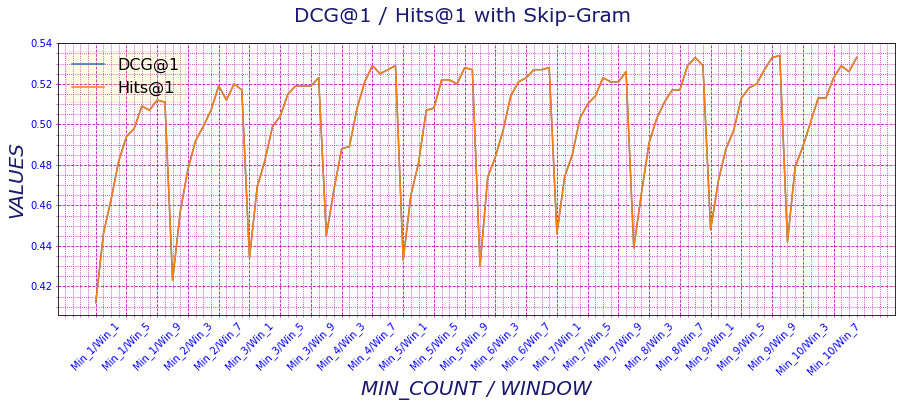

In [270]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('DCG@1 / Hits@1 with Skip-Gram', fontsize=20, fontfamily = 'Verdana', fontstyle = 'normal', color = 'midnightblue')
ax.plot(df.index, df[['DCG@1','Hits@1']])

plt.xticks(np.arange(0, 100, 4),rotation=45)

plt.legend(df[['DCG@1','Hits@1']],loc = 'upper left', shadow = False,
          facecolor = 'yellow', edgecolor = 'r', framealpha = .1, fontsize=16)
plt.tick_params(axis = 'both', which = 'major', direction = 'inout', color = 'm',
               labelcolor = 'b', bottom = True, left = True, labelbottom = True, labelleft = True)
plt.tick_params(axis = 'both', which = 'minor', direction = 'out', color = 'm',
               labelcolor = 'r', bottom = True, left = True)
plt.grid(which='major', color = 'm', linestyle = '--')

plt.minorticks_on()
plt.grid(which='minor', color = 'm', linestyle = ':')

ax.set_xlabel('', fontsize = 20, color = 'midnightblue', fontstyle = 'oblique')
ax.set_ylabel('', fontsize = 20, color = 'midnightblue', fontstyle = 'oblique')
plt.setp(ax, xlabel = 'MIN_COUNT / WINDOW', ylabel = 'VALUES')
plt.show()

### with CBOW

In [272]:
dcg_history = []
hits_history = []
for min_count in range(1,11):
    for window in range(1,11):
        embeddings_trained = Word2Vec(words,                    # data for model to train on
                                      vector_size=200,          # embedding vector size
                                      min_count=min_count,      # Ignores all words with total frequency lower than this. Consider words that occured at least 5 times
                                      window=window,            # Maximum distance between the current and predicted word within a sentence
                                      workers=4,                # Use these many worker threads to train the model
                                      sg=0).wv                  # sg=0 - CBOW, sg=1 - Skip-Gram
        wv_ranking = []
        max_validation_examples = 1000
        tokenizer = MyTokenizer()
        for i, line in enumerate(validation_data):
            if i == max_validation_examples:
                break
            q, *ex = line
            ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
            wv_ranking.append([r[0] for r in ranks].index(0) + 1)
        print(f'min_count = {min_count}, window = {window} with CBOW')
        for k in [1, 5, 10, 100, 500, 1000]:
            print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))
            dcg_history.append(dcg_score(wv_ranking, k))
            hits_history.append(hits_count(wv_ranking, k))
        print()


df2 = pd.DataFrame()
i = m = n = 0
for row in row_list:
    for dcg in columns[:6]:
        df2.loc[row,dcg] = dcg_history[m]
        m+=1
    for hits in columns[6:]:
        df2.loc[row,hits] = hits_history[n]
        n+=1
    i+=6
df2['SUM'] = df2.sum(axis=1)

df2

min_count = 1, window = 1 with CBOW
DCG@   1: 0.358 | Hits@   1: 0.358
DCG@   5: 0.447 | Hits@   5: 0.525
DCG@  10: 0.476 | Hits@  10: 0.614
DCG@ 100: 0.518 | Hits@ 100: 0.824
DCG@ 500: 0.534 | Hits@ 500: 0.949
DCG@1000: 0.540 | Hits@1000: 1.000

min_count = 1, window = 2 with CBOW
DCG@   1: 0.367 | Hits@   1: 0.367
DCG@   5: 0.464 | Hits@   5: 0.550
DCG@  10: 0.485 | Hits@  10: 0.617
DCG@ 100: 0.532 | Hits@ 100: 0.850
DCG@ 500: 0.547 | Hits@ 500: 0.968
DCG@1000: 0.551 | Hits@1000: 1.000

min_count = 1, window = 3 with CBOW
DCG@   1: 0.377 | Hits@   1: 0.377
DCG@   5: 0.470 | Hits@   5: 0.554
DCG@  10: 0.494 | Hits@  10: 0.630
DCG@ 100: 0.541 | Hits@ 100: 0.859
DCG@ 500: 0.556 | Hits@ 500: 0.974
DCG@1000: 0.559 | Hits@1000: 1.000

min_count = 1, window = 4 with CBOW
DCG@   1: 0.385 | Hits@   1: 0.385
DCG@   5: 0.475 | Hits@   5: 0.554
DCG@  10: 0.500 | Hits@  10: 0.634
DCG@ 100: 0.548 | Hits@ 100: 0.866
DCG@ 500: 0.563 | Hits@ 500: 0.976
DCG@1000: 0.565 | Hits@1000: 1.000

min_count = 

min_count = 4, window = 5 with CBOW
DCG@   1: 0.398 | Hits@   1: 0.398
DCG@   5: 0.493 | Hits@   5: 0.576
DCG@  10: 0.518 | Hits@  10: 0.655
DCG@ 100: 0.564 | Hits@ 100: 0.881
DCG@ 500: 0.577 | Hits@ 500: 0.977
DCG@1000: 0.579 | Hits@1000: 1.000

min_count = 4, window = 6 with CBOW
DCG@   1: 0.407 | Hits@   1: 0.407
DCG@   5: 0.498 | Hits@   5: 0.577
DCG@  10: 0.524 | Hits@  10: 0.657
DCG@ 100: 0.570 | Hits@ 100: 0.879
DCG@ 500: 0.583 | Hits@ 500: 0.976
DCG@1000: 0.585 | Hits@1000: 1.000

min_count = 4, window = 7 with CBOW
DCG@   1: 0.397 | Hits@   1: 0.397
DCG@   5: 0.499 | Hits@   5: 0.589
DCG@  10: 0.523 | Hits@  10: 0.662
DCG@ 100: 0.568 | Hits@ 100: 0.883
DCG@ 500: 0.580 | Hits@ 500: 0.976
DCG@1000: 0.583 | Hits@1000: 1.000

min_count = 4, window = 8 with CBOW
DCG@   1: 0.409 | Hits@   1: 0.409
DCG@   5: 0.502 | Hits@   5: 0.585
DCG@  10: 0.525 | Hits@  10: 0.654
DCG@ 100: 0.573 | Hits@ 100: 0.882
DCG@ 500: 0.585 | Hits@ 500: 0.977
DCG@1000: 0.587 | Hits@1000: 1.000

min_count = 

min_count = 7, window = 9 with CBOW
DCG@   1: 0.421 | Hits@   1: 0.421
DCG@   5: 0.509 | Hits@   5: 0.587
DCG@  10: 0.536 | Hits@  10: 0.669
DCG@ 100: 0.580 | Hits@ 100: 0.884
DCG@ 500: 0.592 | Hits@ 500: 0.976
DCG@1000: 0.595 | Hits@1000: 1.000

min_count = 7, window = 10 with CBOW
DCG@   1: 0.412 | Hits@   1: 0.412
DCG@   5: 0.507 | Hits@   5: 0.587
DCG@  10: 0.532 | Hits@  10: 0.663
DCG@ 100: 0.577 | Hits@ 100: 0.882
DCG@ 500: 0.590 | Hits@ 500: 0.979
DCG@1000: 0.592 | Hits@1000: 1.000

min_count = 8, window = 1 with CBOW
DCG@   1: 0.388 | Hits@   1: 0.388
DCG@   5: 0.477 | Hits@   5: 0.558
DCG@  10: 0.506 | Hits@  10: 0.647
DCG@ 100: 0.547 | Hits@ 100: 0.852
DCG@ 500: 0.562 | Hits@ 500: 0.964
DCG@1000: 0.565 | Hits@1000: 1.000

min_count = 8, window = 2 with CBOW
DCG@   1: 0.389 | Hits@   1: 0.389
DCG@   5: 0.483 | Hits@   5: 0.566
DCG@  10: 0.507 | Hits@  10: 0.641
DCG@ 100: 0.553 | Hits@ 100: 0.868
DCG@ 500: 0.566 | Hits@ 500: 0.973
DCG@1000: 0.569 | Hits@1000: 1.000

min_count =

,DCG@1,DCG@5,DCG@10,DCG@100,DCG@500,DCG@1000,Hits@1,Hits@5,Hits@10,Hits@100,Hits@500,Hits@1000,SUM
Min_1/Win_1,0.358,0.447,0.476,0.518,0.534,0.540,0.358,0.525,0.614,0.824,0.949,1.0,7.143
Min_1/Win_2,0.367,0.464,0.485,0.532,0.547,0.551,0.367,0.550,0.617,0.850,0.968,1.0,7.298
Min_1/Win_3,0.377,0.470,0.494,0.541,0.556,0.559,0.377,0.554,0.630,0.859,0.974,1.0,7.391
Min_1/Win_4,0.385,0.475,0.500,0.548,0.563,0.565,0.385,0.554,0.634,0.866,0.976,1.0,7.451
Min_1/Win_5,0.393,0.479,0.509,0.554,0.568,0.571,0.393,0.555,0.648,0.866,0.977,1.0,7.513
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Min_10/Win_6,0.406,0.499,0.522,0.569,0.582,0.584,0.406,0.582,0.652,0.880,0.973,1.0,7.655
Min_10/Win_7,0.412,0.501,0.526,0.573,0.586,0.588,0.412,0.577,0.653,0.880,0.978,1.0,7.686
Min_10/Win_8,0.405,0.503,0.527,0.573,0.586,0.588,0.405,0.586,0.661,0.879,0.978,1.0,7.691
Min_10/Win_9,0.415,0.509,0.533,0.578,0.591,0.593,0.415,0.592,0.665,0.881,0.980,1.0,7.752


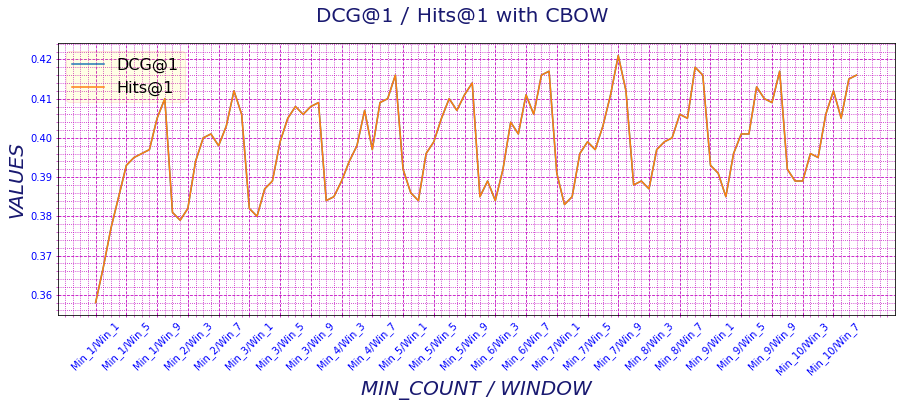

In [277]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('DCG@1 / Hits@1 with CBOW', fontsize=20, fontfamily = 'Verdana', fontstyle = 'normal', color = 'midnightblue')
ax.plot(df2.index, df2[['DCG@1','Hits@1']])

plt.xticks(np.arange(0, 100, 4),rotation=45)

plt.legend(df2[['DCG@1','Hits@1']],loc = 'upper left', shadow = False,
          facecolor = 'yellow', edgecolor = 'r', framealpha = .1, fontsize=16)
plt.tick_params(axis = 'both', which = 'major', direction = 'inout', color = 'm',
               labelcolor = 'b', bottom = True, left = True, labelbottom = True, labelleft = True)
plt.tick_params(axis = 'both', which = 'minor', direction = 'out', color = 'm',
               labelcolor = 'r', bottom = True, left = True)
plt.grid(which='major', color = 'm', linestyle = '--')

plt.minorticks_on()
plt.grid(which='minor', color = 'm', linestyle = ':')

ax.set_xlabel('', fontsize = 20, color = 'midnightblue', fontstyle = 'oblique')
ax.set_ylabel('', fontsize = 20, color = 'midnightblue', fontstyle = 'oblique')
plt.setp(ax, xlabel = 'MIN_COUNT / WINDOW', ylabel = 'VALUES')
plt.show()

In [275]:
# Строка с максимальным значением Hits@1
df2[df2['Hits@1']==df2['Hits@1'].max()]

,DCG@1,DCG@5,DCG@10,DCG@100,DCG@500,DCG@1000,Hits@1,Hits@5,Hits@10,Hits@100,Hits@500,Hits@1000,SUM
Min_7/Win_9,0.421,0.509,0.536,0.58,0.592,0.595,0.421,0.587,0.669,0.884,0.976,1.0,7.77


In [276]:
# Строка с максимальным значением суммы всех метрик (DCG@1 + DCG@5 + .... + Hits@500 + Hits@1000)
df2[df2['SUM']==df2['SUM'].max()]

,DCG@1,DCG@5,DCG@10,DCG@100,DCG@500,DCG@1000,Hits@1,Hits@5,Hits@10,Hits@100,Hits@500,Hits@1000,SUM
Min_10/Win_10,0.416,0.513,0.535,0.581,0.593,0.595,0.416,0.597,0.666,0.886,0.979,1.0,7.777


###### Применим подобранные лучшие значения min_count, window и sg для рассчета значений метрик на разных токенайзерах.

In [21]:
embeddings_trained = Word2Vec(words, # data for model to train on
            vector_size=200,         # embedding vector size
            min_count=9,             # Ignores all words with total frequency lower than this. Consider words that occured at least 5 times
            window=10,               # Maximum distance between the current and predicted word within a sentence
            workers=4,               # Use these many worker threads to train the model
            sg=1).wv                 # sg=0 - CBOW, sg=1 - Skip-Gram

In [74]:
tokenizers = [MyTokenizer(), SpacyTokenizer(), WordPunctTokenizer()]
count=0

for tokenizer in tokenizers:
    wv_ranking = []
    max_validation_examples = 1000
    for i, line in enumerate(validation_data):
        if i == max_validation_examples:
            break
        q, *ex = line
        ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
        wv_ranking.append([r[0] for r in ranks].index(0) + 1)
    if count < 2:
        print(str(tokenizer).split(".")[1].split(" ")[0])
    else:
        print(str(tokenizer).split("(")[0])
    for k in [1, 5, 10, 100, 500, 1000]:
        print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))
    print()
    count+=1

MyTokenizer
DCG@   1: 0.532 | Hits@   1: 0.532
DCG@   5: 0.614 | Hits@   5: 0.683
DCG@  10: 0.635 | Hits@  10: 0.749
DCG@ 100: 0.670 | Hits@ 100: 0.913
DCG@ 500: 0.680 | Hits@ 500: 0.986
DCG@1000: 0.681 | Hits@1000: 1.000

SpacyTokenizer
DCG@   1: 0.508 | Hits@   1: 0.508
DCG@   5: 0.592 | Hits@   5: 0.667
DCG@  10: 0.610 | Hits@  10: 0.724
DCG@ 100: 0.646 | Hits@ 100: 0.894
DCG@ 500: 0.656 | Hits@ 500: 0.974
DCG@1000: 0.659 | Hits@1000: 1.000

WordPunctTokenizer
DCG@   1: 0.505 | Hits@   1: 0.505
DCG@   5: 0.598 | Hits@   5: 0.678
DCG@  10: 0.614 | Hits@  10: 0.730
DCG@ 100: 0.651 | Hits@ 100: 0.906
DCG@ 500: 0.661 | Hits@ 500: 0.979
DCG@1000: 0.663 | Hits@1000: 1.000



#### Эмбеддинги с нормализацией (лемматизацией)

In [98]:
def preproc_nltk_lemma(text):
    text = ' '.join([word for word in word_tokenize(text.lower()) if word not in stopWords])
    return SpacyTokenizer().tokenize(text)
words_lemma = [preproc_nltk_lemma(question) for question in couple_list]

In [99]:
for i in range(5):
    print(words_lemma[i])
    print()

['convert', 'string', 'list', 'convert', 'google', 'result', 'object', '(', 'pure', 'js', ')', 'python', 'object']

['html', '5', 'canvas', 'javascript', 'use', 'make', 'interactive', 'drawing', 'tool', '?', 'event', 'handling', 'geometry', 'three.js', '?']

['send', 'array', 'via', 'ajax', 'fail', 'get', 'list', 'item', 'unordered', 'list', 'php']

['insert', 'cookiecollection', 'cookiecontainer', '?', 'c', '#', 'create', 'cookie', 'string', 'send']

['update', 'one', 'element', 'bind', 'observable', 'collection', 'wpf-', 'update', 'change', 'list', 'item', 'list']



Обучим эмбеддинги с нормализацией на полученных ранее оптимальных параметрах:

In [100]:
embeddings_trained_lemma = Word2Vec(words_lemma, # data for model to train on
            vector_size=200,         # embedding vector size
            min_count=9,             # Ignores all words with total frequency lower than this. Consider words that occured at least 5 times
            window=10,               # Maximum distance between the current and predicted word within a sentence
            workers=4,               # Use these many worker threads to train the model
            sg=1).wv                 # sg=0 - CBOW, sg=1 - Skip-Gram

Проверим качество ранжирования для каждого из трёх токенайзеров:

In [101]:
tokenizers = [MyTokenizer(), SpacyTokenizer(), WordPunctTokenizer()]
count=0

for tokenizer in tokenizers:
    wv_ranking = []
    max_validation_examples = 1000
    for i, line in enumerate(validation_data):
        if i == max_validation_examples:
            break
        q, *ex = line
        ranks = rank_candidates(q, ex, embeddings_trained_lemma, tokenizer)
        wv_ranking.append([r[0] for r in ranks].index(0) + 1)
    if count < 2:
        print(str(tokenizer).split(".")[1].split(" ")[0])
    else:
        print(str(tokenizer).split("(")[0])
    for k in [1, 5, 10, 100, 500, 1000]:
        print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))
    print()
    count+=1

MyTokenizer
DCG@   1: 0.366 | Hits@   1: 0.366
DCG@   5: 0.441 | Hits@   5: 0.507
DCG@  10: 0.459 | Hits@  10: 0.563
DCG@ 100: 0.500 | Hits@ 100: 0.764
DCG@ 500: 0.522 | Hits@ 500: 0.940
DCG@1000: 0.529 | Hits@1000: 1.000

SpacyTokenizer
DCG@   1: 0.375 | Hits@   1: 0.375
DCG@   5: 0.452 | Hits@   5: 0.520
DCG@  10: 0.472 | Hits@  10: 0.583
DCG@ 100: 0.512 | Hits@ 100: 0.779
DCG@ 500: 0.533 | Hits@ 500: 0.940
DCG@1000: 0.539 | Hits@1000: 1.000

WordPunctTokenizer
DCG@   1: 0.352 | Hits@   1: 0.352
DCG@   5: 0.428 | Hits@   5: 0.492
DCG@  10: 0.447 | Hits@  10: 0.552
DCG@ 100: 0.487 | Hits@ 100: 0.753
DCG@ 500: 0.511 | Hits@ 500: 0.937
DCG@1000: 0.517 | Hits@1000: 1.000



### Замечание:
Решить эту задачу с помощью обучения полноценной нейронной сети будет вам предложено, как часть задания в одной из домашних работ по теме "Диалоговые системы".

Напишите свой вывод о полученных результатах.
* Какой принцип токенизации даёт качество лучше и почему?
* Помогает ли нормализация слов?
* Какие эмбеддинги лучше справляются с задачей и почему?
* Почему получилось плохое качество решения задачи?
* Предложите свой подход к решению задачи.

## Вывод:


- Лучшее качество дает токенизация, основанная на регулярных выражениях и возвращающая слова без знаков пунктуации и без применения нормализации, потому что для используемого текста лемматизация дает более худшее ранжирование.
- Нормализация (лемматизация) слов в данном конкретном случае не помогла и ухудшила полученные метрики.
- С задачей лучше всего справляются эмбеддинги с применением технологии Skip-Gram, в которой распределенное представление входного слова используется для прогнозирования контекста. В модели Skip Gram контекстные слова предсказываются с использованием базового слова. Skip-Gram хорошо работает с небольшим объемом обучающих данных, хорошо представляет даже редкие слова или фразы. Модель с CBOW (Continuous Bag of Words), в которой распределенные представления контекста (или окружающих слов) объединяются для прогнозирования слова в середине, показала более худшие результаты. Но при этом CBOW обучается в несколько раз быстрее, чем Skip-Gram, и для частых слов может показать немного лучшую точность. Также более лучшее качество показали эмбеддинги с большим размером гипер-параметра window, характеризующим максимальное расстояние между текущим и прогнозируемым словом в предложении. Гипер-параметр min_count позволяет игнорировать слова, встречающиеся в тексте более чем n раз. Его увеличение приводит к незначительному росту метрик DCG и Hits при прочих равных параметрах. Эмбеддинги с лемматизацией показали более худшие результаты применительно к данному конкретному тексту, вероятно, потому что данный текст является "техническим". Предобученные эмбеддинги показали схожие значения метрик по сравнению с обучаемыми только в диапазоне с min_count=1, window=1, sg=1 (Skip Gram) и оказались хуже всех остальных метрик при увеличении min_count и window. Однако, они превосходят или равны почти всем полученным значениям метрик в случае использования CBOW.
- Плохое качество решения задачи получилось, потому что word2vec не является современным решением. Оно разработано в 2013 году и имеет определенные недостатки: нет информации о предложении или контексте, в котором используется слово, игнорируется совместная встречаемость слов, модель не учитывает то, что слово может иметь различное значение в зависимости от контекста использования, не очень хорошо обрабатывает неизвестные и редкие слова. (по материалам статьи Ilias Miraoui - Master of Engineering Student at Berkeley)
- В качестве улучшения решения можно предложить переход на использование модели GloVe (Global Vectors), которая улучшает Word2Vec, добавляет частоту встречаемости слов и опережает Word2Vec на большинстве бенчмарков. Еще один подход для улучшения результатов - использование библиотеки fastText, которая к основной модели Word2Vec добавлет модель символьных n-грамм. При этом в отличие от Word2Vec и Glove, модель способна генерировать эмбеддинги и для неизвестных слов.